**Importing Libraries**

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split

<h1 align="center">📈Data processing</h1>

<h3 align="center"><B>Importing Data</B></h3>

In [232]:
df = pd.read_csv('Asteroid_Updated.csv', low_memory=False)

In [233]:
df.head()

,name,a,e,i,om,w,q,ad,per_y,data_arc,...,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,Ceres,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,...,0.426,NaN,C,G,0.12,1.59478,MBA,0.213885,1683.145708,77.372096
1,Pallas,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,...,0.284,NaN,B,B,0.11,1.23324,MBA,0.213503,1686.155999,59.699133
2,Juno,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,...,0.433,NaN,Sk,S,0.32,1.03454,MBA,0.226019,1592.787285,34.925016
3,Vesta,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,...,0.492,NaN,V,V,0.32,1.13948,MBA,0.271609,1325.432765,95.861936
4,Astraea,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507.0,...,0.411,NaN,S,S,NaN,1.09589,MBA,0.238632,1508.600458,282.366289


In [234]:
df.spec_T.value_counts().sort_values(ascending=False).head()
# Remove the .head() function above to see the massive amount of classes that spec_B and spec_T contain
# Therefore I am not going to one-hot encode the values

S    338
C    140
X     52
M     38
D     35
Name: spec_T, dtype: int64

<h3 align="center"><B>Cleaning and Processing the Data</B></h3>

In [235]:
# Creating our main Dataset

columns=['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'n_obs_used', 'H', 'diameter', 'albedo', 'rot_per', 'moid','n', 'per', 'ma']
df = df[columns]
# Columns dropped from the original dataset: 
# [extent, GM, IR, BV, UB, G](Because many values were missing)
# [spec_B, spec_T](Contained too many variables(34 each!!!) to apply one hot encoding)
# [neo, pha, class, condition_code](Factors that dont affect diameter))

df = df.dropna(subset=["diameter", "rot_per"]) # Removing null values 
df = df[pd.to_numeric(df['diameter'], errors='coerce').notnull()] # Removing non numeric values
df = df.interpolate() # Substituting Variables. Not a good idea :/ I know
df = df.round(decimals=5) # Rounds Float Values
# Scaling has been performed later
df = df.astype(float)
df = df.reset_index() # Resetting dataframe indexes  

df.head()

,index,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,rot_per,moid,n,per,ma
0,0,2.76917,0.07601,10.59407,80.30553,73.59769,2.55868,2.97965,4.60820,8822.0,1002.0,3.34,939.400,0.0900,9.07417,1.59478,0.21389,1683.14571,77.37210
1,1,2.77247,0.23034,34.83623,173.08006,310.04886,2.13386,3.41107,4.61644,72318.0,8490.0,4.13,545.000,0.1010,7.81320,1.23324,0.21350,1686.15600,59.69913
2,2,2.66915,0.25694,12.98892,169.85276,248.13863,1.98333,3.35497,4.36081,72684.0,7104.0,5.33,246.596,0.2140,7.21000,1.03454,0.22602,1592.78729,34.92502
3,3,2.36142,0.08872,7.14177,103.81080,150.72854,2.15191,2.57093,3.62884,24288.0,9325.0,3.20,525.400,0.4228,5.34213,1.13948,0.27161,1325.43276,95.86194
4,4,2.57425,0.19109,5.36699,141.57660,358.68761,2.08232,3.06617,4.13032,63507.0,2916.0,6.85,106.699,0.2740,16.80600,1.09589,0.23863,1508.60046,282.36629


<h3 align="center"><B>Detecting and Removing Outliers</B></h3>

In [236]:
df.describe()
# displays values according to 'percentile' under every column
# helpful in detecting outliers

,index,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,rot_per,moid,n,per,ma
count,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000
mean,46546.355055,2.779223,0.151047,9.627658,178.126408,175.622736,2.361635,3.196810,4.829628,18146.572540,1568.424153,13.337431,15.334104,0.190998,23.567742,1.381655,0.234552,1764.021784,177.441134
std,75397.173948,1.182410,0.090524,6.914225,103.212009,103.573424,0.810528,1.773194,7.039047,11753.922041,762.840547,2.025789,29.129889,0.141932,74.833025,0.800590,0.093663,2571.012096,103.289109
min,0.000000,0.642200,0.001140,0.042710,0.000740,0.026560,0.092050,0.999960,0.514650,3.000000,51.000000,3.200000,0.002500,0.008000,0.029950,0.000170,0.002490,187.974700,0.057140
25%,3685.500000,2.386760,0.091105,4.405840,92.787525,85.955140,1.987855,2.790070,3.687410,8780.000000,974.500000,12.300000,3.999000,0.070000,4.670500,0.997345,0.187335,1346.826770,88.504820
50%,16033.000000,2.663590,0.139280,8.458100,171.779230,170.507400,2.264330,3.065580,4.347200,13976.000000,1561.000000,13.600000,6.603000,0.171000,7.560000,1.279900,0.226730,1587.815060,175.094900
75%,53910.500000,3.025010,0.192700,13.063225,270.182325,266.079720,2.652795,3.394545,5.261365,24725.000000,2129.500000,14.600000,13.256000,0.273000,14.583000,1.659545,0.267295,1921.714955,264.663175
max,729174.000000,53.920190,0.954480,118.969970,359.915760,359.988890,40.465670,105.385950,395.945420,72684.000000,9325.000000,29.900000,939.400000,1.000000,1880.000000,39.507000,1.915150,144619.064200,359.989550


In [237]:
# Removing Outliers
# These value were determined using the Seaborn widget above
df = df[df.a < 20]
df = df[df.q < 6]
df = df[df.n_obs_used < 6000]
df = df[df.per_y < 15]
df = df[df.diameter < 400]
df = df.reset_index()

<h3 align="center"><B>Looking for Correlations</B></h3>

In [238]:
# prints the correlations between diameter and all other attributes 
# A correlation of 1 suggests that the variable increases when diameter increases
# -1 suggests that the variable decreases when diameter increases
# 0 suggests no relation
corr_matrix = df.corr()
corr_matrix["diameter"].sort_values(ascending=False)

diameter      1.000000
data_arc      0.647487
n_obs_used    0.486019
a             0.336844
per           0.332031
per_y         0.332031
ad            0.317814
moid          0.317460
q             0.312393
i             0.090785
ma            0.042665
w             0.026346
rot_per      -0.003568
om           -0.024062
e            -0.084419
n            -0.233910
index        -0.248551
albedo       -0.295540
level_0      -0.514822
H            -0.750045
Name: diameter, dtype: float64

*H is the only variable that shares a clear correlation with diameter*</br>
*You will see this affect the Decision tree*

<h3 align="center"><B>Creating a Target Dataset</B></h3>

In [239]:
# Creating a target Dataset

df1 = df.copy()
y = df1.pop('diameter')
df1.head()

,level_0,index,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,albedo,rot_per,moid,n,per,ma
0,4,4,2.57425,0.19109,5.36699,141.57660,358.68761,2.08232,3.06617,4.13032,63507.0,2916.0,6.85,0.2740,16.8060,1.09589,0.23863,1508.60046,282.36629
1,6,6,2.38533,0.23121,5.52365,259.56323,145.26511,1.83383,2.93684,3.68410,62452.0,5206.0,5.51,0.2766,7.1390,0.84610,0.26753,1345.61920,140.41966
2,7,7,2.20176,0.15650,5.88695,110.88933,285.28746,1.85719,2.54634,3.26711,62655.0,2744.0,6.49,0.2260,12.8650,0.87418,0.30168,1193.31372,194.88290
3,8,8,2.38564,0.12311,5.57682,68.90858,6.41737,2.09193,2.67934,3.68481,61821.0,2649.0,6.28,0.1180,5.0790,1.10691,0.26748,1345.87536,276.86162
4,10,10,2.45311,0.10047,4.62989,125.54659,195.55040,2.20664,2.69958,3.84223,61755.0,5492.0,6.55,0.1910,13.7204,1.19322,0.25652,1403.37519,278.93069


<h3 align="center"><B>Splitting the Data</B></h3>

**Stratified Sampling**</br>
[Click to know more](https://www.youtube.com/watch?v=sYRUYJYOpG0) <br>

<AxesSubplot:>

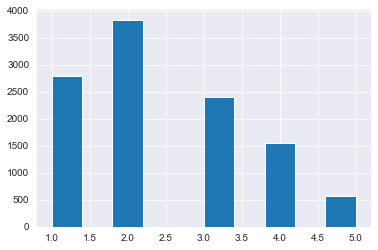

In [274]:
# Now we will perform stratified sampling
# we will divide the data into groups according to diameter
# so that we can split the dataset into train and test samples such that both the samples have equal proportions of all groups

df['diameter_grp'] = pd.cut(df['diameter'],
                            bins=[0., 4., 8., 18., 60., np.inf], # diameter values 0-4 in grp 1, 4-8 in grp 2, etc. 
                            labels=[1, 2, 3, 4, 5]) # name of groups

df["diameter_grp"].hist() # shows the number of samples in each diameter group

In [241]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(test_size=0.2, random_state=1)
# Lets go with a smaller test size as we have a lot of data

for train_index, test_index in split.split(df, df['diameter_grp']):
    dftrain = df.loc[train_index]
    dftest =  df.loc[test_index]

dftrain.pop("level_0")
dftrain.pop("index")
dftest.pop("level_0")
dftest.pop("index")

# Creating a target Dataset
ytrain = dftrain.pop('diameter')
ytest = dftest.pop('diameter')

In [242]:
df['diameter_grp'].value_counts() / len(df) 
# proprtions of each group in original dataset

2    0.343551
1    0.250964
3    0.215380
4    0.138747
5    0.051358
Name: diameter_grp, dtype: float64

In [243]:
dftrain['diameter_grp'].value_counts() / len(dftrain) 
# proprtions of each group in splitted dataset
# As you can see, the proportions from original dataset are almost equal to the splitted dataset.

2    0.343529
1    0.250980
3    0.215350
4    0.138711
5    0.051429
Name: diameter_grp, dtype: float64

In [244]:
# Now that we have splitted the data proportionally, we no longer need diameter_grp column
# If we keep it, it may interfere with the training of the model

for set_ in(dftrain, dftest):
    set_.drop("diameter_grp", axis=1, inplace=True)
dftrain.head()

,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,albedo,rot_per,moid,n,per,ma
9644,3.14309,0.13676,14.43500,182.58524,101.73042,2.71325,3.57293,5.57242,24511.0,836.0,14.0,0.071,10.814,1.74389,0.17688,2035.32535,108.75065
7496,2.60796,0.10832,14.39217,186.25717,101.52556,2.32546,2.89046,4.21172,10101.0,1474.0,13.8,0.168,3.480,1.36032,0.23402,1538.33054,253.84377
3674,2.23647,0.10110,3.04870,333.83792,107.90532,2.01036,2.46258,3.34466,24072.0,1887.0,13.4,0.249,14.269,1.02863,0.29469,1221.63700,149.37106
1952,3.13889,0.11470,14.42354,174.65515,166.40103,2.77886,3.49893,5.56126,31635.0,2285.0,11.4,0.061,11.600,1.77258,0.17723,2031.24972,24.07332
7335,3.13897,0.19450,14.32578,281.82393,191.48415,2.52844,3.74950,5.56146,8186.0,1298.0,12.7,0.059,7.859,1.54692,0.17722,2031.32429,8.83503


In [245]:
#  Creating scaled datasets

# It is suggested to scale data before using Lasso
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
sdftrain = scale.fit_transform(dftrain)
sdftest = scale.fit_transform(dftest)
sdftrain # All the values now lie between 0 to 1

array([[0.49048984, 0.15172738, 0.22500543, ..., 0.05708164, 0.38197459,
        0.30198311],
       [0.38553688, 0.1199096 , 0.22433584, ..., 0.08807703, 0.27921154,
        0.70509524],
       [0.31267798, 0.1118321 , 0.04699489, ..., 0.12098725, 0.21372918,
        0.41483877],
       ...,
       [0.39775749, 0.22167278, 0.18150202, ..., 0.08366151, 0.29067936,
        0.97733438],
       [0.34767865, 0.14314642, 0.05243965, ..., 0.10359642, 0.2445587 ,
        0.4919245 ],
       [0.39305243, 0.01096393, 0.0553677 , ..., 0.08532682, 0.28624806,
        0.76176858]])

<h1 align="center">📊Seaborn Widget</h1>

In [275]:
# This widget helped me a lot to find relation between variables and detect Outliers
# Open in jupyter notebook, as you cannot access this in git
from ipywidgets import interactive
def size_widget(height=5.5, aspect=2.5, Y='diameter', X='ma', Kind='scatter'):
    sns.pairplot(df, hue='diameter_grp', palette='RdYlBu', x_vars=X, y_vars=Y, height=height, aspect=aspect, kind=Kind)

- Y: Column to plot on Y-axis
- X: Column to plot on X-axis
- Kind: Type of graph (kde will take time to load)

In [276]:
interactive(size_widget, X = columns, Y= columns,  height=(3, 10, 0.25), aspect=(0.6, 2.5, 0.5), Kind=['scatter','hist','reg','kde'])

interactive(children=(FloatSlider(value=5.5, description='height', max=10.0, min=3.0, step=0.25), FloatSlider(…

<h1 align="center">🤖Implementing ML models</h1>

<h3 align="center"><B>Linear Regression</B></h3>

In [248]:
from sklearn.linear_model import LinearRegression
# Scaled data not used since it fails in Linear Regression
model = LinearRegression()
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([15.74553638, 23.9511359 , 33.49711578, ..., 21.27304556,
       21.44163091,  6.42846593])

*Performace metrics*

In [249]:
# Low Performance may be because none of the variables in the dataset share a linear relationship with diameter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
linearMSE = mean_squared_error(pred,ytest)
linearRMSE = mean_squared_error(pred,ytest, squared=False)
linearMAE = mean_absolute_error(pred, ytest)
print(linearMSE)
print(linearRMSE)
print(linearMAE)


175.66093311569216
13.253713936693071
8.43612876253584


<h3 align="center"><B>Lasso</B></h3>

In [250]:
from sklearn.linear_model import Lasso

# Lasso on unscaled data
# Unscaled data produces negative predictions
model = Lasso()
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([17.95047925, 22.61377044, 43.53863178, ..., 16.97706911,
       20.70715364,  2.7395412 ])

In [251]:
Lasso_unscaledMSE = mean_squared_error(pred,ytest)
# Unscaled data is giving less error
Lasso_unscaledRMSE = mean_squared_error(pred,ytest, squared=False) 
Lasso_unscaledMAE = mean_absolute_error(pred, ytest)
print(Lasso_unscaledMSE)
print(Lasso_unscaledRMSE)
print(Lasso_unscaledMAE)

194.45647188457013
13.944765035115154
8.796108152993838


In [252]:
# Lasso on scaled data
# Scaled data eliminates negative predictions in Lasso 
model = Lasso()
model.fit(sdftrain, ytrain)
pred = model.predict(sdftest)
pred  

array([12.89661993, 13.03221715, 35.66141302, ..., 10.10657318,
       27.23681531, 12.1145331 ])

In [253]:
Lasso_scaledMSE = mean_squared_error(pred,ytest)
# Scaled data giving higher error
Lasso_scaledRMSE = mean_squared_error(pred,ytest, squared=False) 
print(Lasso_scaledMSE)
print(Lasso_scaledRMSE)

292.8020865057817
17.111460677153826


- Inference: Lasso performs better on unscaled data

<h3 align="center"><B>Ridge</B></h3>

In [254]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([15.64498367, 23.7297116 , 33.06924446, ..., 21.00340326,
       21.71016074,  6.67615006])

In [255]:
RidgeMSE = mean_squared_error(pred, ytest)
RidgeRMSE = mean_squared_error(pred, ytest, squared=False)
RidgeMAE = mean_absolute_error(pred, ytest)
print(RidgeMSE)
print(RidgeRMSE)
print(RidgeMAE)

175.25074187551698
13.238230315095631
8.414708181925345


<h3 align="center"><B>Decision Tree</B></h3>

In [256]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=0, max_depth= 4)
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([ 8.47870779, 16.20717735, 26.52348062, ...,  6.93116885,
        8.47870779,  6.93116885])

In [257]:
# Visualizing our decision tree
# Requires dtreeviz to be installed on your pc 
# Commented out to prevent interuption 
# Else you can find the visualization in the README.md file

#from dtreeviz.trees import *
#from IPython.display import Image, display_svg, SVG
#columns=['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'n_obs_used', 'H', 'albedo', 'rot_per', 'moid','n', 'per', 'ma']

#viz = dtreeviz(model, sdftrain, ytrain, feature_names=columns, target_name='diameter')
#viz.save("decision_tree.svg")
#viz

*We previously saw that H showed a clear negative trend with respect to diameter*</br>
*In the above visualization of the decision tree we can see that H is the variable used in most of the nodes*

In [258]:
Decision_treeMSE = mean_squared_error(pred, ytest)
Decision_treeRMSE = mean_squared_error(pred, ytest, squared=False)
Decision_treeMAE = mean_absolute_error(pred, ytest)
print(Decision_treeMSE)
print(Decision_treeRMSE)
print(Decision_treeMAE)

30.6590125561964
5.537058113853998
2.9915500929828727


- I also tried Cost-complexity-pruning on Decision Tree but it didn't seem to have any special effect.  
[Click to know more](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) <br>

<h3 align="center"><B>Random Forest</B></h3>

In [259]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0, max_depth=10)
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([ 9.22228031, 14.74881878, 17.14611237, ..., 12.98454231,
        7.37731318,  7.05059384])

In [260]:
RandomForestMSE = mean_squared_error(pred, ytest)
RandomForestRMSE = mean_squared_error(pred, ytest, squared=False)
RandomForestMAE = mean_absolute_error(pred, ytest)
print(RandomForestMSE)
print(RandomForestRMSE)
print(RandomForestMAE)

10.400693143315879
3.2250105648378704
1.178764860364035


<h3 align="center"><B>Random Forest with Hyperparameter Tuning</B></h3>

In [261]:
# Parameter grid that we will use to tune RandomForest

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [262]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [263]:
# Running GridSearchCV to find the best parameters for our model

# Commented out for better performace while running the notebook
#rf_Model = RandomForestRegressor()
#from sklearn.model_selection import GridSearchCV
#rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
#rf_Grid.fit(sdftrain, ytrain)
#rf_Grid.best_params_

In [264]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap=True, max_depth=4, max_features = 'auto', min_samples_leaf=2, min_samples_split=5, n_estimators=25, random_state=1)
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([ 9.00015085, 11.93338245, 22.67549958, ...,  9.13104636,
        9.00015085,  5.8478923 ])

In [265]:
RandomForest_hyperMSE = mean_squared_error(pred, ytest)
# This model offers performance similar to the one without Hyperparameter optimization
RandomForest_hyperRMSE = mean_squared_error(pred, ytest, squared=False)
RandomForest_hyperMAE = mean_absolute_error(pred, ytest)
print(RandomForest_hyperMSE)
print(RandomForest_hyperRMSE)
print(RandomForest_hyperMAE)

17.28743048410192
4.157815590439519
2.292163022281441


<h3 align="center"><B>Support Vector Regressor</B></h3>

In [266]:
from sklearn.svm import SVR

model = SVR()
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([ 8.87441747,  9.4193603 , 39.82507643, ...,  7.55984496,
       14.72158554,  5.06346433])

In [267]:
svr_MSE = mean_squared_error(pred, ytest)
svr_RMSE = mean_squared_error(pred, ytest, squared=False)
svr_MAE = mean_absolute_error(pred, ytest)
print(svr_MSE)
print(svr_RMSE)
print(svr_MAE)

209.44214595420257
14.472116153286034
6.342710138962517


<h3 align="center"><B>KNN Regressor</B></h3>

In [268]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(sdftrain, ytrain)
pred = model.predict(sdftest)
pred

array([13.59  , 26.2858, 14.5602, ..., 14.593 , 15.6618, 12.2358])

In [269]:
knn_MSE = mean_squared_error(pred, ytest)
knn_RMSE = mean_squared_error(pred, ytest, squared=False)
knn_MAE = mean_absolute_error(pred, ytest)
print(knn_MSE)
print(knn_RMSE)
print(knn_MAE)

190.45876224704753
13.800679774817164
7.484726388888888


<h3 align="center"><B>XGBoost Regressor</B></h3>

In [270]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(dftrain, ytrain)
pred = model.predict(dftest)
pred

array([ 9.534056 , 14.767688 , 13.324388 , ..., 13.817564 ,  7.4006014,
        7.2259784], dtype=float32)

In [271]:
xgb_MSE = mean_squared_error(pred, ytest)
xgb_RMSE = mean_squared_error(pred, ytest, squared=False)
xgb_MAE = mean_absolute_error(pred, ytest)
print(xgb_MSE)
print(xgb_RMSE)
print(xgb_MAE)

9.867930689883902
3.141326262883864
1.2129299725643274


<h1 align="center">☄️Comparing the Models</h1>

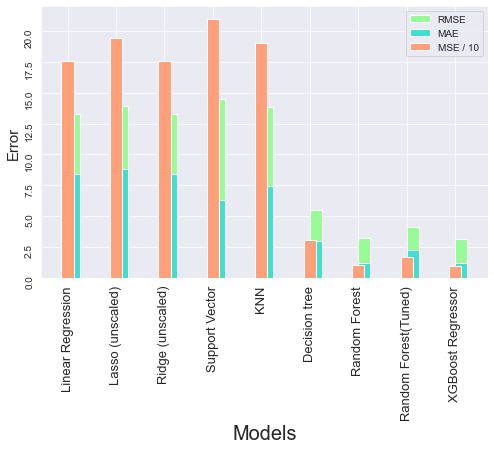

In [272]:
import matplotlib.pyplot as plt

models=['Linear Regression', 'Lasso (unscaled)', 'Ridge (unscaled)', 'Support Vector', 'KNN', 'Decision tree', 'Random Forest', 'Random Forest(Tuned)', 'XGBoost Regressor' ]
ValuesM=[linearMSE/10, Lasso_unscaledMSE/10, RidgeMSE/10, svr_MSE/10, knn_MSE/10, Decision_treeMSE/10, RandomForestMSE/10, RandomForest_hyperMSE/10, xgb_MSE/10]
ValuesR=[linearRMSE, Lasso_unscaledRMSE, RidgeRMSE, svr_RMSE, knn_RMSE, Decision_treeRMSE, RandomForestRMSE, RandomForest_hyperRMSE, xgb_RMSE]
ValuesA=[linearMAE, Lasso_unscaledMAE, RidgeMAE, svr_MAE, knn_MAE, Decision_treeMAE, RandomForestMAE, RandomForest_hyperMAE, xgb_MAE]
ypos = np.arange(len(models))

#size of graph
plt.figure(figsize=(8, 5))
#angle of x ticks
plt.xticks(rotation=90, fontsize=13)
plt.yticks(rotation=90, fontsize=10)
# Plotting RMSE
plt.bar(models, ValuesR, width=0.25, align='edge', color='palegreen', label = "RMSE")
# Plotting MAE
plt.bar(models, ValuesA, width=0.25, align='edge', color='turquoise', label = "MAE")
# Plotting MSE
plt.bar(models, ValuesM, width=0.25, color='lightsalmon', label="MSE / 10")
plt.xlabel("Models", fontsize = 20)
plt.ylabel("Error", fontsize= 15, rotation= 90)
plt.legend()

# MSE has been scaled down by a factor of 10